In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Lang Class with some helper functions for word to idx and vice versa

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # the above two tokens
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
            
        else:
            self.word2count[word] += 1
            

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/nlp-data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
# filter out sentences based on max-length, punctuations, etc to create a smaller dataset

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['nous descendons .', 'we re going down .']


### Encoder RNN

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_size)
        
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size)
        
    def forward(self, input, hidden):
        
        embedded = self.embedding(input).view(1, 1, -1) # needs to be a 3d tensor
        output = embedded
        
        output, hidden = self.gru(output, hidden)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder RNN

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        self.gru = nn.GRU(hidden_size, hidden_size)
        
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        
        output, hidden = self.gru(output, hidden)
        # output is an array with a single value
        # so we take the 0th element
        output = self.softmax(self.output(output[0])) 
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder RNN with Seq2Seq Attention 
Some issue with this implementation since the attention weights alpha_i is computed only since the decoder input and hidden state at time t !

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_Size, output_size, 
                 dropout_p=0.1, max_length=MAX_LENGTH):
        
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
    
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
        
    def forward(self, input, hidden, encoder_outputs):
        
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        # this calculation of alpha_i doesnt use info from the encoder outputs!
        # this is the hidden state from the previous time step
        # the assumption is that previous hidden state has some info about the enc outputs since it was calculated using those
        # this is not a straightforward way to apply attn, but works
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], 
                                                      hidden[0]), 1)), dim=1)
                                
        
        # batch matrix multiplication
        # between the alpha_i and encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), 
                                 encoder_outputs.unsqueeze(0))
        
        # concatenate above attention vector a_t and the embedding input
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        
        # linear transform
        output = self.attn_combine(output).unsqueeze(0)
        # non-linearity
        output = F.relu(output)
        
        # finally feed it to the Gru for computing 
        # hidden state and output of the current step
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

Helper functions for preparing data

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Model Training 
We will use teacher forcing to enable the model to learn better

In [14]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    # encoder and decoder are defined as two separate classes
    # hence 2 optimizers ?
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    # create an initial tensor to store encoder outputs
    encoder_outputs = torch.zeros(max_length, 
                                  encoder.hidden_size, 
                                  device=device)

    loss = 0
    
    # for each index in the input sequence
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # decoder input at the first time step 
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # hidden state initialization at the end of encoding process
    decoder_hidden = encoder_hidden
    
    # next we specify whether to use teacher forcing or not
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # sum up the losses for all timesteps
            loss += criterion(decoder_output, target_tensor[di])
            
            # decoder input for the next time step
            # is the target token at the current timestep
            decoder_input = target_tensor[di]  # Teacher forcing
            
    else:
        # Without teacher forcing: use predicted words as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # the argmax TopK @ k=1 gives the index of the predicted token
            topv, topi = decoder_output.topk(1)
            
            decoder_input = topi.squeeze().detach()  
            # detach from history as input 
            
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token: # stop when EOS is reached
                break
                
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length # average loss per token
    

Set of helper functions to track training progress

In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [17]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

During evaluation, the procedure is almost the same. Just need to stop decoding when EOS is reached. Also, to return the attention weights

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and evaluation

2m 17s (- 31m 59s) (5000 6%) 2.9212
4m 24s (- 28m 41s) (10000 13%) 2.3319
6m 25s (- 25m 43s) (15000 20%) 2.0073
8m 38s (- 23m 46s) (20000 26%) 1.7936
10m 51s (- 21m 43s) (25000 33%) 1.5862
13m 0s (- 19m 31s) (30000 40%) 1.4468
15m 3s (- 17m 12s) (35000 46%) 1.2752
17m 5s (- 14m 57s) (40000 53%) 1.1312
19m 10s (- 12m 47s) (45000 60%) 1.0550
21m 17s (- 10m 38s) (50000 66%) 0.9359
23m 27s (- 8m 31s) (55000 73%) 0.8665
25m 34s (- 6m 23s) (60000 80%) 0.7643
27m 41s (- 4m 15s) (65000 86%) 0.6787
29m 52s (- 2m 8s) (70000 93%) 0.6460
31m 58s (- 0m 0s) (75000 100%) 0.5697


<Figure size 432x288 with 0 Axes>

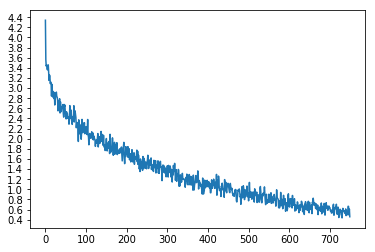

In [21]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [22]:
evaluateRandomly(encoder1, attn_decoder1)

> c est un homme jaloux .
= he is a jealous man .
< he s a jealous man . <EOS>

> je suis completement en vrac .
= i m completely wrecked .
< i m completely already . <EOS>

> j ai faim !
= i am hungry .
< i m hungry . <EOS>

> nous nous retirons .
= we re pulling back .
< we re getting out . <EOS>

> nous aurons une nouvelle voiture le mois prochain .
= we re getting a new car next month .
< we are working for a new month . <EOS>

> je ne suis pas sur d aimer ca .
= i m not sure i like this .
< i m not sure i like this . <EOS>

> je suis sur .
= i am sure .
< i m sure . <EOS>

> tu le sous estimes .
= you are selling him short .
< you are making of the choir . <EOS>

> il a le vin mauvais .
= he is an angry drunk .
< he is an angry drunk . <EOS>

> je suis libre tous les jours sauf lundi .
= i m free every day but monday .
< i m free on every day . <EOS>



### Visualizing Attention

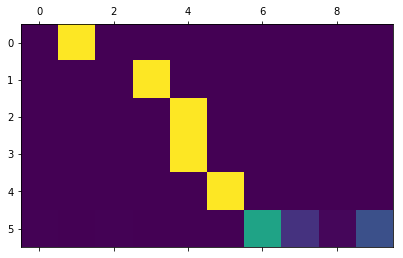

In [23]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience 

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


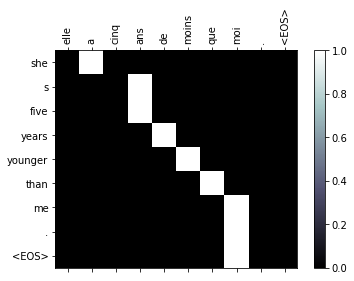

input = elle est trop petit .
output = she s too short . <EOS>


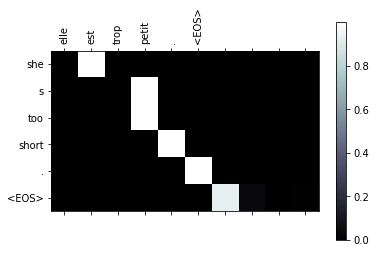

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


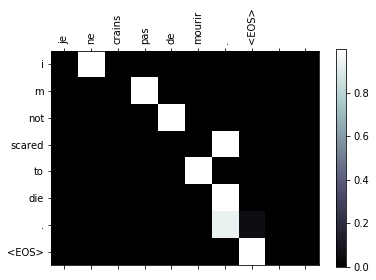

input = c est un jeune directeur plein de talent .
output = he s very young young . <EOS>


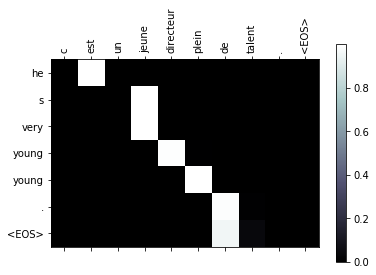

In [24]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")